In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

import src.visualization.visualize as VizManager
import src.features.build_features as FeaturesManager

In [4]:
seasons_year = [2015, 2016, 2017, 2018]
features_data_df = FeaturesManager.build_features(seasons_year)
features_data_df.describe()

,Event Index,Period,X,Y,Last event X,Last event Y,Last event elapsed time,Last event distance,st_X,st_Y,...,Last event st_Y,Shot distance,Shot angle,Is Goal,Is Empty,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event
count,298117.000000,298117.000000,298117.000000,298117.000000,295999.000000,295999.000000,298117.000000,295999.000000,298117.000000,298117.000000,...,295999.000000,298117.000000,298117.000000,298117.000000,298117.000000,298117.000000,295999.000000,298117.000000,298115.000000,290398.000000
mean,163.967644,2.044218,-0.104667,-0.234166,0.002334,-0.076760,15.178514,61.839354,58.221587,-0.042128,...,0.068260,36.215253,-0.808445,0.094896,0.007296,1836.201367,-0.073188,0.199492,7.370928,7.992434
std,94.513498,0.873830,63.486543,18.967836,64.765102,22.890049,14.788746,46.294134,25.313781,18.969235,...,22.890076,25.226693,36.559168,0.293071,0.085103,1061.375766,44.391739,0.399619,19.668555,10.181108
min,2.000000,1.000000,-99.000000,-42.000000,-100.000000,-42.000000,0.000000,0.000000,-99.000000,-42.000000,...,-42.000000,0.000000,-173.659808,0.000000,0.000000,0.000000,-174.289407,0.000000,0.000000,0.000000
25%,82.000000,1.000000,-64.000000,-14.000000,-69.000000,-22.000000,5.000000,26.019224,45.000000,-14.000000,...,-22.000000,17.029386,-28.551392,0.000000,0.000000,926.000000,-21.583969,0.000000,0.000000,2.109502
50%,162.000000,2.000000,-3.000000,0.000000,0.000000,0.000000,10.000000,46.615448,63.000000,0.000000,...,0.000000,33.060551,0.000000,0.000000,0.000000,1819.000000,0.000000,0.000000,0.000000,4.684015
75%,242.000000,3.000000,64.000000,13.000000,69.000000,22.000000,21.000000,92.612094,77.000000,14.000000,...,22.000000,49.578221,27.299572,0.000000,0.000000,2734.000000,21.531788,0.000000,0.000000,10.005554
max,448.000000,5.000000,99.000000,42.000000,99.000000,42.000000,194.000000,200.000000,99.000000,42.000000,...,42.000000,189.654950,180.000000,1.000000,1.000000,3900.000000,180.000000,1.000000,209.528672,186.625293


In [44]:
names_all = list(features_data_df.columns) 


names = ['Period', 'Shot Type', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Is Empty', 'Rebound', 'Change in Shot Angle', 
         'Speed From Previous Event', 'Game seconds', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance',
         'Is Goal']

feature_names, target_name = names[0:-2], names[-1]
feature_names = np.array(feature_names)

df_filter = features_data_df[names]

print(feature_names)

# Be careful with dropna. For example, if we choose the 'Strenght' feature, if will remove all the shots
df_filter = df_filter.dropna()

df_filter[df_filter.isna().any(axis=1)]

['Period' 'Shot Type' 'st_X' 'st_Y' 'Shot distance' 'Shot angle'
 'Is Empty' 'Rebound' 'Change in Shot Angle' 'Speed From Previous Event'
 'Game seconds' 'Last event st_X' 'Last event st_Y'
 'Last event elapsed time']


,Period,Shot Type,st_X,st_Y,Shot distance,Shot angle,Is Empty,Rebound,Change in Shot Angle,Speed From Previous Event,Game seconds,Last event st_X,Last event st_Y,Last event elapsed time,Last event distance,Is Goal


In [45]:
df_filter.describe()

,Period,st_X,st_Y,Shot distance,Shot angle,Is Empty,Rebound,Change in Shot Angle,Speed From Previous Event,Game seconds,Last event st_X,Last event st_Y,Last event elapsed time,Last event distance,Is Goal
count,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000,290367.000000
mean,2.022306,58.015019,-0.037787,36.477876,-0.795671,0.004549,0.195298,7.359253,7.991980,1820.943881,23.674967,0.072019,15.535474,61.731347,0.090727
std,0.838634,25.298966,19.084764,25.173392,36.657236,0.067296,0.396430,19.715140,10.180564,1050.020060,60.148546,22.992072,14.770141,45.912234,0.287220
min,1.000000,-99.000000,-42.000000,1.000000,-173.659808,0.000000,0.000000,0.000000,0.000000,3.000000,-99.000000,-42.000000,1.000000,0.000000,0.000000
25%,1.000000,45.000000,-14.000000,17.464249,-28.610460,0.000000,0.000000,0.000000,2.109502,919.000000,-34.000000,-22.000000,5.000000,26.248809,0.000000
50%,2.000000,63.000000,0.000000,33.421550,0.000000,0.000000,0.000000,0.000000,4.683831,1806.000000,50.000000,0.000000,11.000000,46.690470,0.000000
75%,3.000000,76.000000,14.000000,49.769469,27.474432,0.000000,0.000000,0.000000,10.005101,2714.000000,69.000000,22.000000,21.000000,91.760558,0.000000
max,4.000000,99.000000,42.000000,189.654950,180.000000,1.000000,1.000000,209.528672,186.625293,3900.000000,100.000000,42.000000,194.000000,200.000000,1.000000


In [46]:
dummy_shot_type = pd.get_dummies(df_filter['Shot Type'], prefix='Shot Type')
df_filter = df_filter.merge(dummy_shot_type, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Shot Type'])

# Update features_name
feature_names = list(df_filter.columns)
feature_names = [f for f in feature_names if f != 'Is Goal']
feature_names = np.array(feature_names)
print(feature_names)


df_filter.sample(10)
print

['Period' 'st_X' 'st_Y' 'Shot distance' 'Shot angle' 'Is Empty' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event' 'Game seconds'
 'Last event st_X' 'Last event st_Y' 'Last event elapsed time'
 'Last event distance' 'Shot Type_Backhand' 'Shot Type_Deflected'
 'Shot Type_Slap Shot' 'Shot Type_Snap Shot' 'Shot Type_Tip-In'
 'Shot Type_Wrap-around' 'Shot Type_Wrist Shot']


<function print>

In [47]:
df_train, df_valid = train_test_split(df_filter, test_size=0.2, random_state=42)

In [48]:
X_train = df_train[feature_names].to_numpy()
y_train = df_train[target_name].to_numpy()

X_valid = df_valid[feature_names].to_numpy()
y_valid = df_valid[target_name].to_numpy()


In [49]:
X_train.mean()

96.82208131137436

In [50]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)


# Lasso SVC
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_train_scaled, y_train)

# Select features based on Lasso
model = SelectFromModel(lsvc)

model.fit(X_train_scaled,y_train)

print('Selected Support : ', model.get_support())

print('Selected Features: ', feature_names[model.get_support()])
print('Rejected Features: ', feature_names[~model.get_support()])

# features = model.transform(X_train)
# print('Selected Features shape: ', features.shape)

Selected Support :  [ True  True False  True False  True  True  True  True False False False
  True  True  True  True  True False  True  True  True]
Selected Features:  ['Period' 'st_X' 'Shot distance' 'Is Empty' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event'
 'Last event elapsed time' 'Last event distance' 'Shot Type_Backhand'
 'Shot Type_Deflected' 'Shot Type_Slap Shot' 'Shot Type_Tip-In'
 'Shot Type_Wrap-around' 'Shot Type_Wrist Shot']
Rejected Features:  ['st_Y' 'Shot angle' 'Game seconds' 'Last event st_X' 'Last event st_Y'
 'Shot Type_Snap Shot']


In [51]:
# p (1-p) - Only for Boolean features
# Remove all features that are either one or zero (on or off) in more than (100*p)% of the samples
p = 0.9
selector = VarianceThreshold(threshold=(p * (1 - p)))
features = selector.fit_transform(X_train)

print('Selected Features: ', feature_names[selector.get_support()])
print('Rejected Features: ', feature_names[~selector.get_support()])

Selected Features:  ['Period' 'st_X' 'st_Y' 'Shot distance' 'Shot angle' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event' 'Game seconds'
 'Last event st_X' 'Last event st_Y' 'Last event elapsed time'
 'Last event distance' 'Shot Type_Slap Shot' 'Shot Type_Snap Shot'
 'Shot Type_Wrist Shot']
Rejected Features:  ['Is Empty' 'Shot Type_Backhand' 'Shot Type_Deflected' 'Shot Type_Tip-In'
 'Shot Type_Wrap-around']


In [52]:
# Feature Selection with chi-square

# Features should be non negative. 
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)
X_valid_minmax = min_max_scaler.transform(X_valid)

# Selection
num_features = 12
selector = SelectKBest(score_func=chi2, k=num_features)
fit = selector.fit(X_train_minmax, y_train)

features = fit.transform(X_train_minmax)

scores = fit.scores_.argsort()[::-1]
print('Selected Features: ', feature_names[scores][:num_features])
print('Rejected Features: ', feature_names[scores][num_features:])

Selected Features:  ['Is Empty' 'Shot Type_Tip-In' 'Shot distance' 'Shot Type_Slap Shot'
 'Shot Type_Deflected' 'Rebound' 'Shot Type_Backhand' 'st_X' 'Period'
 'Game seconds' 'Speed From Previous Event' 'Change in Shot Angle']
Rejected Features:  ['Shot Type_Wrist Shot' 'Last event elapsed time' 'Last event distance'
 'Last event st_X' 'Shot Type_Wrap-around' 'Shot Type_Snap Shot' 'st_Y'
 'Shot angle' 'Last event st_Y']


In [53]:
from sklearn.ensemble import RandomForestClassifier

clf_forest =  RandomForestClassifier(random_state=0).fit(X_train_minmax, y_train)

classifiers = [(clf_forest, 'Random Forest', X_valid_minmax, y_valid)]

# VizManager.plot_all_figures(classifiers, add_random=True)

In [54]:
import time

start_time = time.time()
importances = clf_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

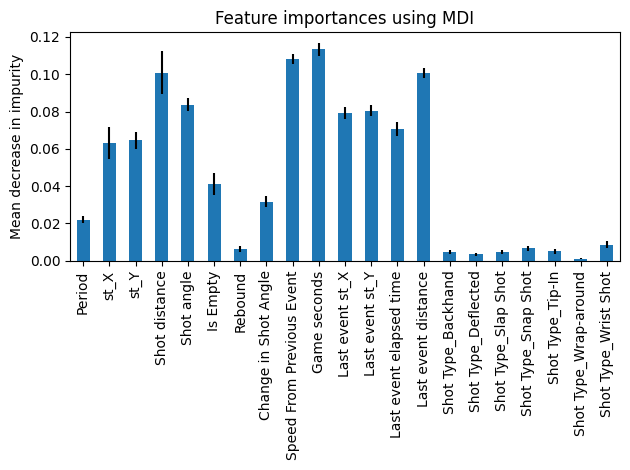

In [55]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") # Mean Decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [56]:
# from sklearn.inspection import permutation_importance

# start_time = time.time()
# result = permutation_importance(
#     clf_forest, X_valid_minmax, y_valid, n_repeats=5, random_state=42, n_jobs=2
# )
# elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# forest_importances = pd.Series(result.importances_mean, index=feature_names)

: 

: 

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf_forest, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()